In [10]:
# %%
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
import re
from torch.cuda.amp import autocast, GradScaler
import time

DEVICE = torch.device("cuda")
K = 10 
MAX_LEN = 50 


Data Extraction

In [11]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

min_movie_ratings = 5
min_user_ratings = 5

while True:
    movie_counts = ratings['movieId'].value_counts()
    valid_movies = movie_counts[movie_counts >= min_movie_ratings].index
    ratings = ratings[ratings['movieId'].isin(valid_movies)]
    
    user_counts = ratings['userId'].value_counts()
    valid_users = user_counts[user_counts >= min_user_ratings].index
    ratings = ratings[ratings['userId'].isin(valid_users)]
    
    if len(ratings['movieId'].unique()) == len(valid_movies) and \
       len(ratings['userId'].unique()) == len(valid_users):
        break


ratings['movieId'] = ratings['movieId'].astype(str)
ratings['userId'] = ratings['userId'].astype(str)
movies['movieId'] = movies['movieId'].astype(str)

def extract_year_bucket(title):
    match = re.search(r'\((\d{4})\)$', title.strip())
    if match:
        year = int(match.group(1))
        if year == 0: return 0   
        if year < 1970: return 1 
        if year < 1975: return 2
        if year < 1980: return 3
        if year < 1985: return 4
        if year < 1990: return 5
        if year < 1995: return 6
        if year < 2000: return 7
        if year < 2005: return 8
        if year < 2010: return 9
        if year < 2015: return 10
        if year < 2020: return 11
        return 12    
    return 0
movies['year_bucket'] = movies['title'].apply(extract_year_bucket)

movie_id_to_title = dict(zip(movies['movieId'], movies['title']))
movie_id_to_year = dict(zip(movies['movieId'], movies['year_bucket']))
movie_id_to_genres = {}

unique_genres = set()
for idx, row in movies.iterrows():
    g_list = row['genres'].split('|')
    movie_id_to_genres[row['movieId']] = g_list
    unique_genres.update(g_list)

all_movies = sorted(ratings['movieId'].unique())
movie_to_idx = {mid: i+1 for i, mid in enumerate(all_movies)} 
idx_to_movie = {i: m for m, i in movie_to_idx.items()}
num_movies = len(all_movies) + 1

all_genres = sorted(list(unique_genres))
genre_to_idx = {g: i+1 for i, g in enumerate(all_genres)}
num_genres = len(all_genres) + 1

movie_idx_to_genre_idx = {} 
movie_idx_to_year_idx = {} 

for mid, m_idx in movie_to_idx.items():
    gs = movie_id_to_genres.get(mid, [])
    movie_idx_to_genre_idx[m_idx] = genre_to_idx[gs[0]] if gs else 0
    movie_idx_to_year_idx[m_idx] = movie_id_to_year.get(mid, 0)

ratings_sorted = ratings.sort_values(by=['userId', 'timestamp'])
user_timeline_id = ratings_sorted.groupby('userId')['movieId'].apply(list).to_dict()

train_timeline = {u: seq[:-1] for u, seq in user_timeline_id.items() if len(seq) > 1}



In [12]:
print(f"Original Size: {len(ratings)} ratings, {len(ratings['movieId'].unique())} movies")
min_movie_ratings = 5
min_user_ratings = 5

while True:
    movie_counts = ratings['movieId'].value_counts()
    valid_movies = movie_counts[movie_counts >= min_movie_ratings].index
    ratings = ratings[ratings['movieId'].isin(valid_movies)]
    
    user_counts = ratings['userId'].value_counts()
    valid_users = user_counts[user_counts >= min_user_ratings].index
    ratings = ratings[ratings['userId'].isin(valid_users)]
    
    if len(ratings['movieId'].unique()) == len(valid_movies) and \
       len(ratings['userId'].unique()) == len(valid_users):
        break

Original Size: 24945870 ratings, 32720 movies


In [13]:
global_probs = ratings['movieId'].value_counts(normalize=True).to_dict()
popularity_rankings = ratings['movieId'].value_counts().index.tolist()

genre_to_popular = defaultdict(list)
for mid in popularity_rankings:
    for g in movie_id_to_genres.get(mid, []):
        genre_to_popular[g].append(mid)

Global Pop Hit Rate: 0.0445
Genre Pop Hit Rate:  0.0384


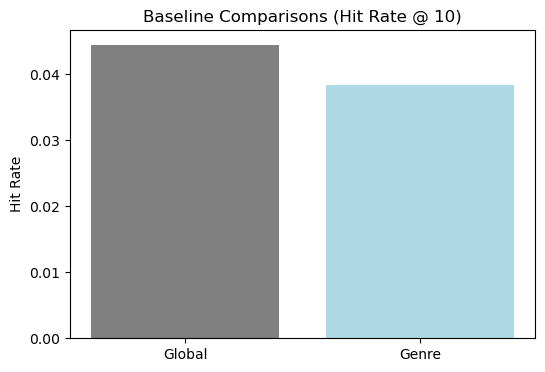

In [14]:
def predict_global(history, k=10):
    recs = []
    seen = set(history)
    for m in popularity_rankings:
        if m not in seen:
            recs.append(m)
            if len(recs) == k: break
    return recs

def predict_genre(history, k=10):
    user_genres = []
    for m in history:
        user_genres.extend(movie_id_to_genres.get(m, []))
    
    if not user_genres: return predict_global(history, k)
    
    fav_genre = Counter(user_genres).most_common(1)[0][0]
    
    recs = []
    seen = set(history)
    
    for m in genre_to_popular[fav_genre]:
        if m not in seen:
            recs.append(m)
            if len(recs) == k: return recs
            
    for m in popularity_rankings:
        if m not in seen and m not in recs:
            recs.append(m)
            if len(recs) == k: break
    return recs

hits_global = 0
hits_genre = 0
total = 0

for user, full_seq in user_timeline_id.items():
    if len(full_seq) < 2: continue
    total += 1
    target = full_seq[-1]
    history = full_seq[:-1]
    
    if target in predict_global(history, K): hits_global += 1
    if target in predict_genre(history, K): hits_genre += 1

score_global = hits_global / total
score_genre = hits_genre / total

print(f"Global Pop Hit Rate: {score_global:.4f}")
print(f"Genre Pop Hit Rate:  {score_genre:.4f}")

# --- Graph ---
plt.figure(figsize=(6, 4))
plt.bar(['Global', 'Genre'], [score_global, score_genre], color=['gray', 'lightblue'])
plt.title(f"Baseline Comparisons (Hit Rate @ {K})")
plt.ylabel("Hit Rate")
plt.show()

In [ ]:
transitions = defaultdict(lambda: defaultdict(int))

for seq in train_timeline.values():
    for i in range(len(seq) - 1):
        prev, next_m = seq[i], seq[i+1]
        transitions[prev][next_m] += 1

sorted_transitions = {}
for prev, next_dict in transitions.items():
    total = sum(next_dict.values())
    sorted_list = [(m, count/total) for m, count in next_dict.items()]
    sorted_list.sort(key=lambda x: x[1], reverse=True)
    sorted_transitions[prev] = sorted_list

In [ ]:
def predict_markov(history, k=10):
    last_movie = history[-1]
    recs = []
    seen = set(history)  
    
    if last_movie in sorted_transitions:
        recs = [m for m, p in sorted_transitions[last_movie] if m not in seen]  # ✓ Fixed
    
    if len(recs) < k:
        for m in popularity_rankings:
            if m not in seen and m not in recs:
                recs.append(m)
                if len(recs) == k: break
    
    return recs[:k]

Markov Chain Hit Rate: 0.1413


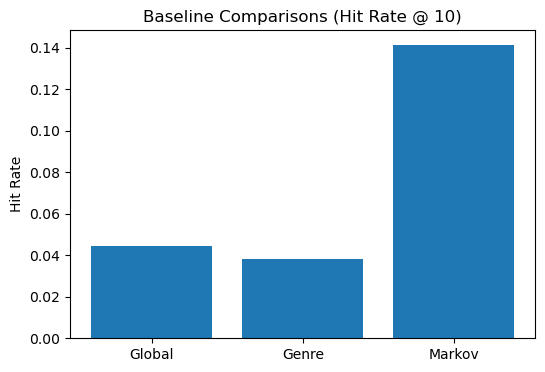

In [ ]:
hits_markov = 0
total = 0

for user, full_seq in user_timeline_id.items():
    total += 1
    target = full_seq[-1]
    history = full_seq[:-1]
    
    if target in predict_markov(history, K): hits_markov += 1

score_markov = hits_markov / total
print(f"Markov Chain Hit Rate: {score_markov:.4f}")
plt.figure(figsize=(6, 4))
plt.bar(['Global', 'Genre', 'Markov'], [score_global, score_genre, score_markov])
plt.title(f"Baseline Comparisons (Hit Rate @ {K})")
plt.ylabel("Hit Rate")
plt.show()

In [ ]:
user_score_cache = {} 

top_1000_global = popularity_rankings[:1000]

for user, full_seq in user_timeline_id.items():
    
    target = full_seq[-1]
    history = full_seq[:-1]
    last_movie = history[-1]
    
    candidates = set(top_1000_global)
    markov_cands = sorted_transitions.get(last_movie, [])
    
    markov_dict = {}
    for m, p in markov_cands:
        candidates.add(m)
        markov_dict[m] = p
    
    seen = set(history)
    final_candidates = list(candidates - seen)
    
    if not final_candidates: continue

    m_vec = np.array([markov_dict.get(m, 0.0) for m in final_candidates])
    g_vec = np.array([global_probs.get(m, 0.0) for m in final_candidates])
    ids_vec = np.array(final_candidates)
    
    user_score_cache[user] = {
        'target': target,
        'ids': ids_vec,
        'm_vec': m_vec,
        'g_vec': g_vec
    }

Cached 162541 users for Grid Search.


In [ ]:
def get_hybrid_recs(user_id, alpha, k=10):
    data = user_score_cache.get(user_id)
    if not data: return []
    
    scores = (alpha * data['m_vec']) + ((1.0 - alpha) * data['g_vec'])
    
    if len(scores) > k:
        top_indices_unsorted = np.argpartition(scores, -k)[-k:]
        top_scores = scores[top_indices_unsorted]
        sorter = np.argsort(-top_scores)
        final_indices = top_indices_unsorted[sorter]
    else:
        final_indices = np.argsort(-scores)
        
    return data['ids'][final_indices]

Alpha  | Hit Rate  
--------------------
0.0    | 0.0445
0.1    | 0.1142
0.2    | 0.1452
0.3    | 0.1566
0.4    | 0.1595
0.5    | 0.1597
0.6    | 0.1596
0.7    | 0.1593
0.8    | 0.1590
0.9    | 0.1590
1.0    | 0.1585

Best Hybrid Hit Rate: 0.1597 (Alpha=0.5)


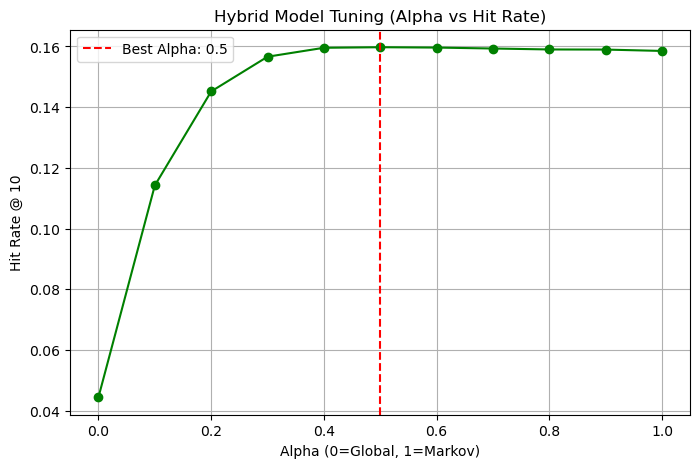

In [ ]:
alpha_values = np.linspace(0, 1, 11)
results = {}

print(f"{'Alpha':<6} | {'Hit Rate':<10}")
print("-" * 20)

for alpha in alpha_values:
    hits = 0
    total = len(user_timeline_id) 
    
    for user_id, data in user_score_cache.items():
        recs = get_hybrid_recs(user_id, alpha, K)
        
        if data['target'] in recs:
            hits += 1
            
    hr = hits / total
    results[alpha] = hr
    print(f"{alpha:<6.1f} | {hr:.4f}")

best_alpha = max(results, key=results.get)
print(f"\nBest Alpha: {best_alpha:.1f} (Score: {results[best_alpha]:.4f})")
print(f"Markov Score: {score_markov:.4f}")
print(f"Hybrid (1.0): {results[1.0]:.4f}")

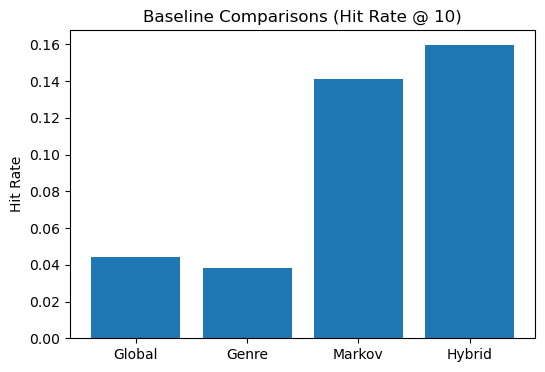

In [20]:
plt.figure(figsize=(6, 4))
plt.bar(['Global', 'Genre', 'Markov', 'Hybrid'], [score_global, score_genre, score_markov, score_hybrid])
plt.title(f"Baseline Comparisons (Hit Rate @ {K})")
plt.ylabel("Hit Rate")
plt.show()

In [ ]:
transitions_ar2 = defaultdict(lambda: defaultdict(int))
for seq in train_timeline.values():
    if len(seq) < 3: continue
    for i in range(len(seq) - 2):
        p1, p2, target = seq[i], seq[i+1], seq[i+2]
        transitions_ar2[(p1, p2)][target] += 1

sorted_transitions_ar2 = {}
for state, next_dict in transitions_ar2.items():
    total = sum(next_dict.values())
    sorted_list = [(m, count/total) for m, count in next_dict.items()]
    sorted_list.sort(key=lambda x: x[1], reverse=True)
    sorted_transitions_ar2[state] = sorted_list

In [ ]:
hybrid_fallback_map = {}

for user_id in user_score_cache:
    recs = get_hybrid_recs(user_id, best_alpha, K + 5)
    hybrid_fallback_map[user_id] = recs

def predict_ar2(user_id, history, k=10):
    if len(history) < 2:
        return hybrid_fallback_map.get(user_id, [])[:k]
    
    last_two = tuple(history[-2:])
    recs = []
    seen = set(history)
    
    if last_two in sorted_transitions_ar2:
        recs = [m for m, p in sorted_transitions_ar2[last_two] if m not in seen]
    
    if len(recs) < k:
        fallback = hybrid_fallback_map.get(user_id, [])
        for m in fallback:
            if m not in seen and m not in recs:
                recs.append(m)
                if len(recs) == k: break
                
    return recs[:k]

In [ ]:
hits_ar2 = 0
total = 0

for user, full_seq in user_timeline_id.items():
    total += 1
    target = full_seq[-1]
    history = full_seq[:-1]
    
    if target in predict_ar2(user, history, K):
        hits_ar2 += 1

score_ar2 = hits_ar2 / total

0.16768076977501062


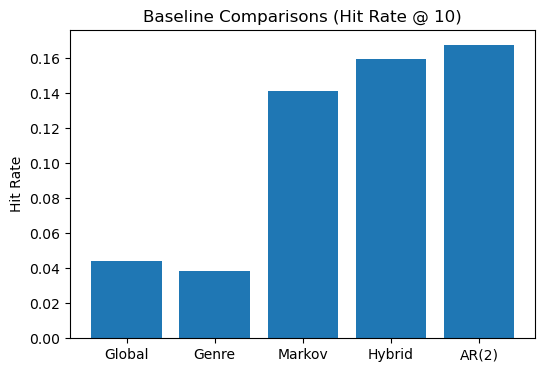

In [25]:
plt.figure(figsize=(6, 4))
plt.bar(['Global', 'Genre', 'Markov', 'Hybrid', 'AR(2)'], [score_global, score_genre, score_markov, score_hybrid, score_ar2])
plt.title(f"Baseline Comparisons (Hit Rate @ {K})")
plt.ylabel("Hit Rate")
plt.show()

In [ ]:
MAX_LEN = 200
def build_seq_tensors(timeline_dict, max_len):
    num_users = len(timeline_dict)
    input_ids = np.zeros((num_users, max_len), dtype=np.int32)
    target_ids = np.zeros((num_users, max_len), dtype=np.int32)
    user_list = list(timeline_dict.keys())

    for i, user in enumerate(user_list):
        seq = timeline_dict[user]
        seq_int = [movie_to_idx.get(m, 0) for m in seq]
        if len(seq_int) < 2: continue
        full_input = seq_int[:-1]
        full_target = seq_int[1:]
        if len(full_input) > max_len:
            full_input = full_input[-max_len:]
            full_target = full_target[-max_len:]
        length = len(full_input)
        input_ids[i, -length:] = full_input
        target_ids[i, -length:] = full_target
    return (torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long))
train_in, train_tgt = build_seq_tensors(train_timeline, MAX_LEN)
test_in, test_tgt = build_seq_tensors(user_timeline_id, MAX_LEN)
train_gen = torch.zeros_like(train_in)
train_yr = torch.zeros_like(train_in)
test_gen = torch.zeros_like(test_in)
test_yr = torch.zeros_like(test_in)

In [ ]:
class SASRecDatasetSeq(Dataset):
    def __init__(self, inputs, genres, years, targets):
        self.inputs = inputs
        self.genres = genres
        self.years = years
        self.targets = targets
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.genres[idx], self.years[idx], self.targets[idx]

In [ ]:
class SASRecModel(nn.Module):
    def __init__(self, num_movies, num_genres, num_years, embed_dim=256, max_len=200, num_heads=4, num_layers=3, dropout=0.1):
        super(SASRecModel, self).__init__()
        self.movie_embedding = nn.Embedding(num_movies, embed_dim, padding_idx=0)
        self.genre_embedding = nn.Embedding(num_genres, embed_dim, padding_idx=0)
        self.year_embedding = nn.Embedding(num_years, embed_dim, padding_idx=0)
        self.position_embedding = nn.Embedding(max_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, dim_feedforward=embed_dim*4, batch_first=True, norm_first=True, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(embed_dim, num_movies)
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.apply(self._init_weights)

       

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_seq, input_genres, input_years):
        batch_size, seq_len = input_seq.size()
        movie_embeds = self.movie_embedding(input_seq)
        genre_embeds = self.genre_embedding(input_genres)
        year_embeds = self.year_embedding(input_years)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_seq.device).unsqueeze(0).expand(batch_size, -1)
        position_embeds = self.position_embedding(position_ids)
        x = movie_embeds + position_embeds
        x = self.dropout(x)
        attn_mask = torch.triu(torch.ones((seq_len, seq_len), device=input_seq.device) * float('-inf'), diagonal=1).bool()
        x = self.transformer_encoder(x, mask=attn_mask)
        logits = self.output_layer(x)
        return logits

In [ ]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
BATCH_SIZE = 128
EPOCHS = 20      
DROPOUT = 0.2    
train_ds = SASRecDatasetSeq(train_in, train_gen, train_yr, train_tgt)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
model = SASRecModel(num_movies, num_genres, num_years=13,
                    embed_dim=512, max_len=MAX_LEN,
                    num_layers=4, num_heads=4,
                    dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scaler = torch.amp.GradScaler('cuda')
print("Starting Full-Sequence Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    step = 0
    t0 = time.time()
    for batch in train_loader:
        step += 1
        m, g, y, t = [b.to(DEVICE) for b in batch]
        if t.sum() == 0: continue
        optimizer.zero_grad()
        with torch.amp.autocast('cuda', dtype=torch.float16):
            logits = model(m, g, y)
            loss = criterion(logits.view(-1, num_movies), t.view(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        if step % 50 == 0:

            elapsed = time.time() - t0

            print(f"Ep {epoch+1} | Step {step} | Loss {loss.item():.4f} | {elapsed:.1f}s")

            t0 = time.time()

Model is on: cuda:0
CUDA available: True


In [ ]:
test_ds = SASRecDatasetSeq(test_in, test_gen, test_yr, test_tgt)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

model = SASRecModel(num_movies, num_genres, num_years=13,

                    embed_dim=512, max_len=MAX_LEN,

                    num_layers=4, num_heads=4,

                    dropout=DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('sasrec_epoch_11_stuck.pth'))
model.eval()
hits = 0
total = 0
K = 10

with torch.no_grad():
    for batch in test_loader:
        m, g, y, t = [b.to(DEVICE) for b in batch]
        logits = model(m, g, y)
        last_logits = logits[:, -1, :] # [Batch, Vocab]
        last_targets = t[:, -1]        # [Batch]
        _, top_indices = torch.topk(last_logits, K, dim=1)
        for i in range(len(last_targets)):
            target = last_targets[i]
            if target == 0: continue
            total += 1
            if target in top_indices[i]:
                hits += 1



print(f"Hit Rate @ {K}: {hits/total:.4f}")